In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, visualize_prior, model_graph, traceplot
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

#### Get top 50 series

In [3]:
data = data[data.sum(axis=0).sort_values(ascending=False)[:10].index]

In [4]:
groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [5]:
groups = generate_groups_data_flat(data, groups_input, seasonality=12, h=24)

Number of groups: 4
	state: 3
	zone: 5
	region: 7
	purpose: 3
Total number of series: 10
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [6]:
m = HGPforecaster(groups_data=groups, 
                  n_iterations = 100000,
                  likelihood='normal')#,
                  #minibatch=[100, 20]
                 #)

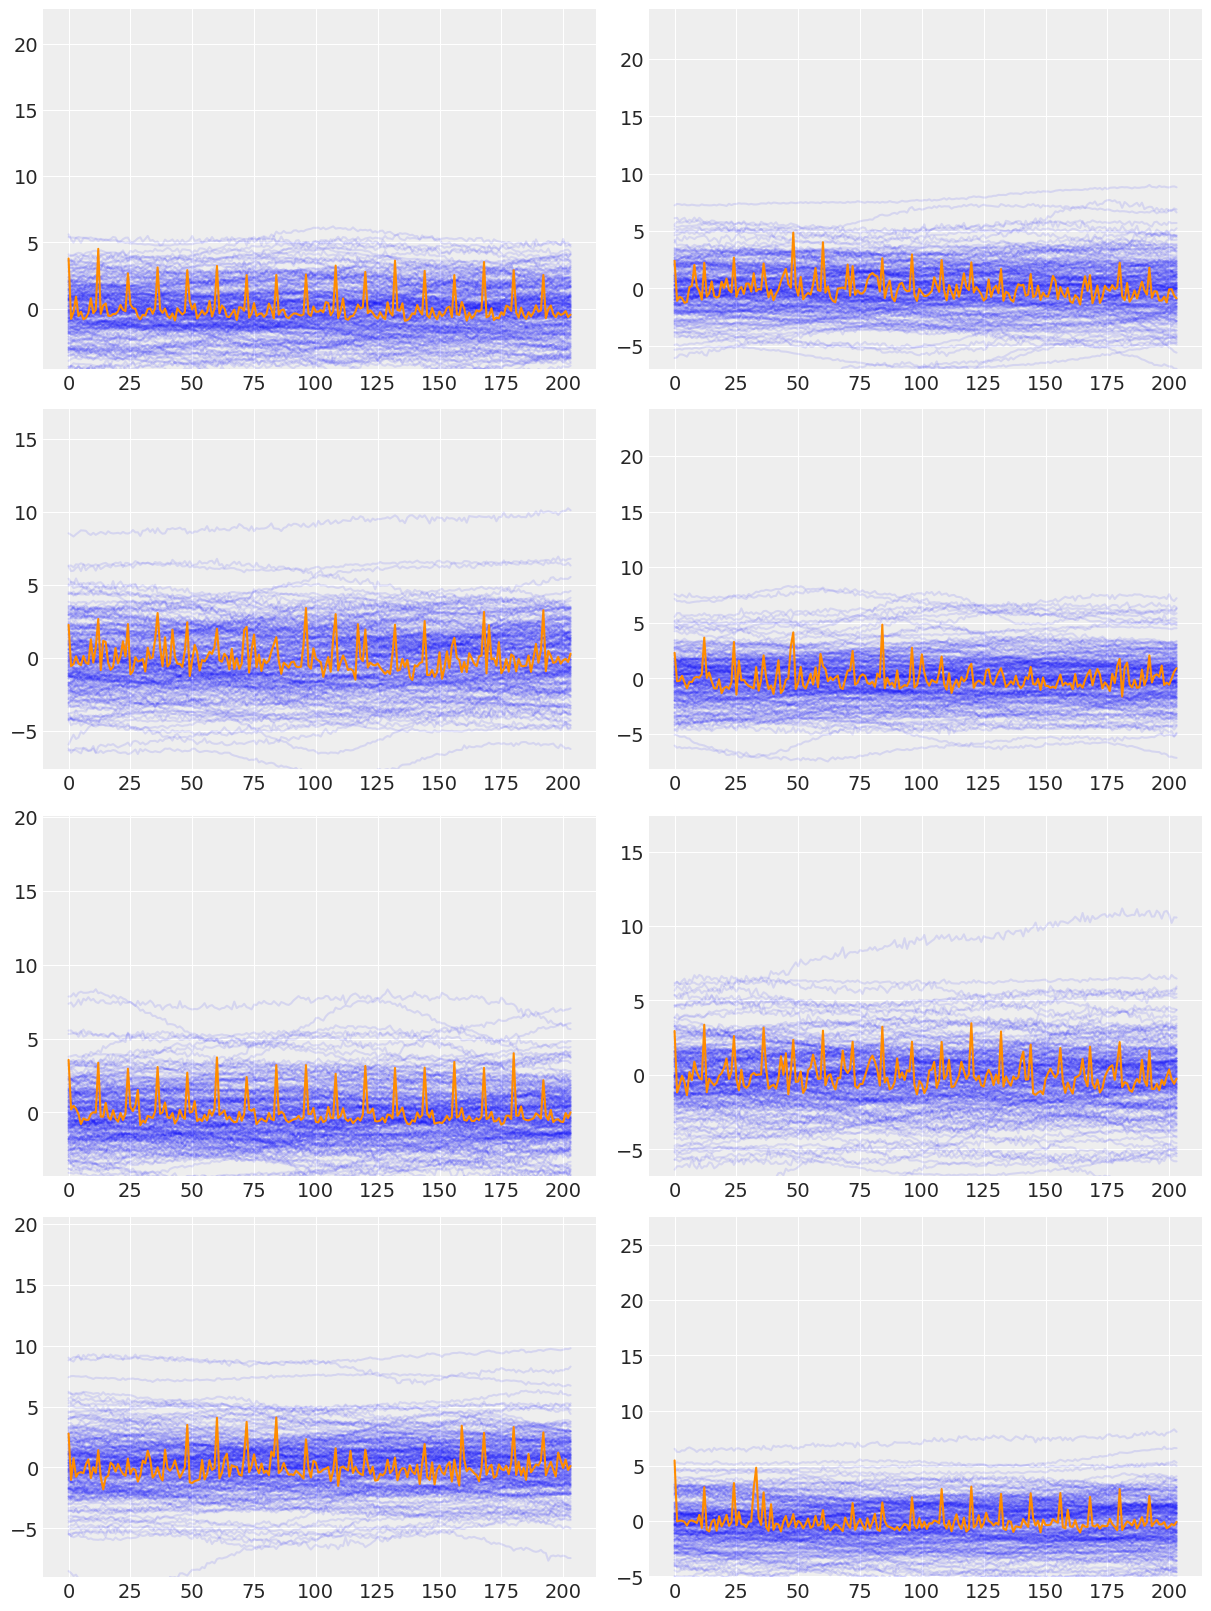

In [7]:
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [8]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 6,636.6


Sampling...


In [9]:
m.predict()

Sampling...


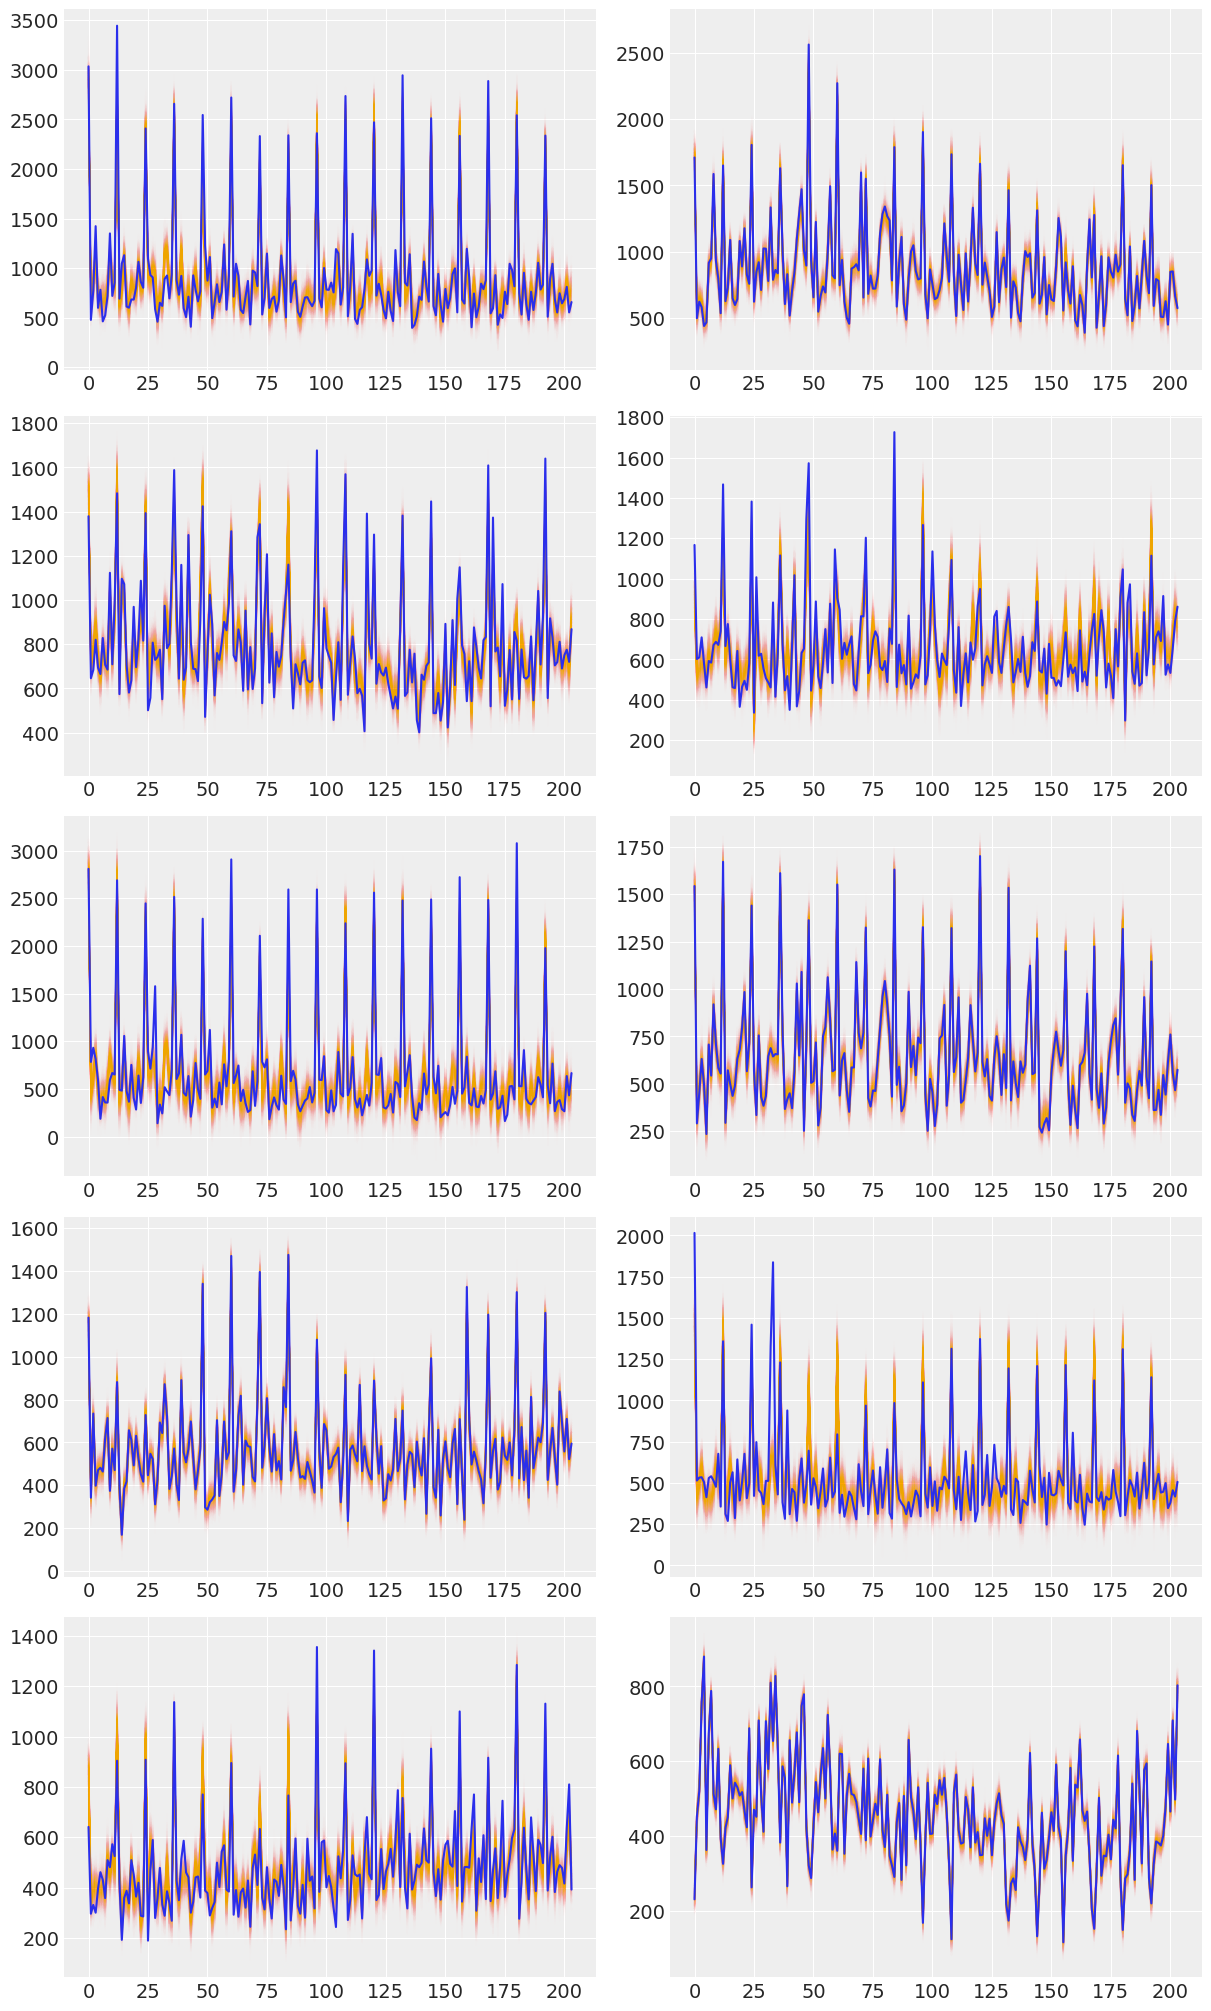

In [10]:
visualize_fit(groups, m.pred_samples_fit, 10)

In [43]:
m.g['predict']['groups_idx'][group]

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 0])

In [45]:
idx_dict_new

{'A': array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1]),
 'B': array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 'C': array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0]),
 'AA': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1]),
 'AB': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'AC': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'BA': array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 'CA': array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0]),
 'AAA': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1]),
 'ABB': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'ACA': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'BAA': array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 'CAA': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'CAB': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'CAC': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'Bus': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 'Hol': array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0]),
 'Vis': array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0])}

In [53]:
(f_new['A'].reshape((-1,1))*idx_dict_new[name].reshape((1,-1))).tag.test_value.shape

(228, 10)

In [61]:
m.g['predict']['groups_names'][group]

array(['Bus', 'Hol', 'Vis'], dtype='<U3')

In [62]:
m.g['train']['groups_names'][group]

array(['Bus', 'Hol', 'Vis'], dtype='<U3')

In [28]:
import numpy as np
import pymc3 as pm
f_new = {}
f_flat_new = {}
idx_dict_new = {}

n_new = m.g['predict']['n']
X_new = np.arange(n_new).reshape(-1,1)

with m.model:
    for group in m.levels:
        for idx, name in enumerate(m.g['predict']['groups_names'][group]):
            idx_dict_new[name] = np.where(m.g['predict']['groups_idx'][group]==idx,1,0)
            f_new[name] = m.gp_dict[name].conditional('f_______new%s'%name, Xnew = X_new)
            f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

    f_ = sum(f_flat_new.values())
    
    y_pred_new = pm.Normal("y_pred____new", 
                    mu=f_, 
                    sd=m.priors['sigma'],
                    shape=(n_new, m.g['predict']['s']))

    pred_samples_predict = pm.sample_posterior_predictive(m.trace_vi_samples, 
                              vars=[y_pred_new], 
                              samples=500)

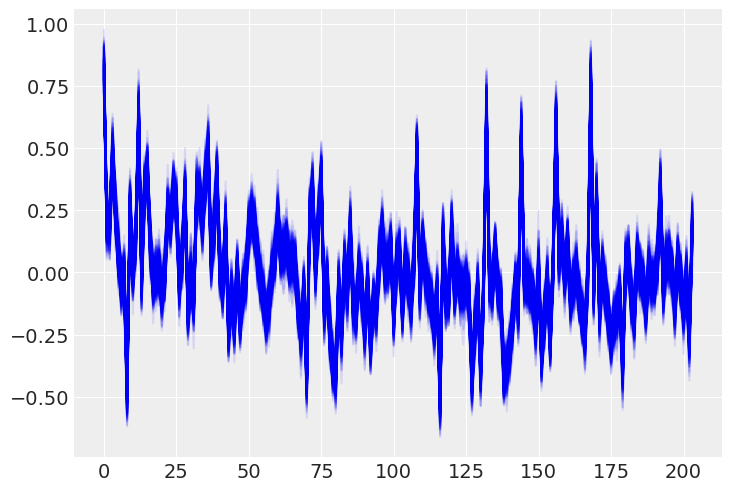

In [68]:
plt.plot(m.trace_vi_samples['f_A'].T, color='b', alpha=0.1);

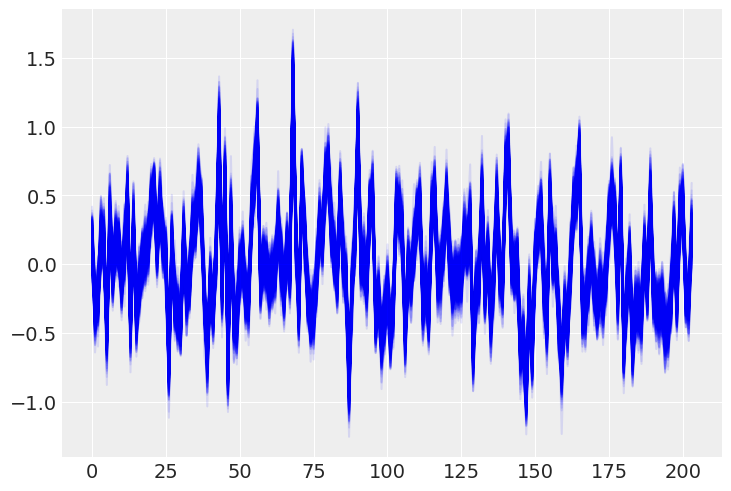

In [80]:
plt.plot(m.trace_vi_samples['f_CAC'].T, color='b', alpha=0.1);

In [55]:
m.g['train']['groups_idx']

{'state': array([0, 2, 0, 1, 0, 2, 2, 0, 1, 0]),
 'zone': array([1, 4, 0, 3, 2, 4, 4, 0, 3, 0]),
 'region': array([1, 4, 0, 3, 2, 6, 5, 0, 3, 0]),
 'purpose': array([1, 1, 2, 2, 1, 1, 2, 1, 1, 0])}

In [57]:
f_new

{'A': f_______newA,
 'B': f_______newB,
 'C': f_______newC,
 'AA': f_______newAA,
 'AB': f_______newAB,
 'AC': f_______newAC,
 'BA': f_______newBA,
 'CA': f_______newCA,
 'AAA': f_______newAAA,
 'ABB': f_______newABB,
 'ACA': f_______newACA,
 'BAA': f_______newBAA,
 'CAA': f_______newCAA,
 'CAB': f_______newCAB,
 'CAC': f_______newCAC,
 'Bus': f_______newBus,
 'Hol': f_______newHol,
 'Vis': f_______newVis}

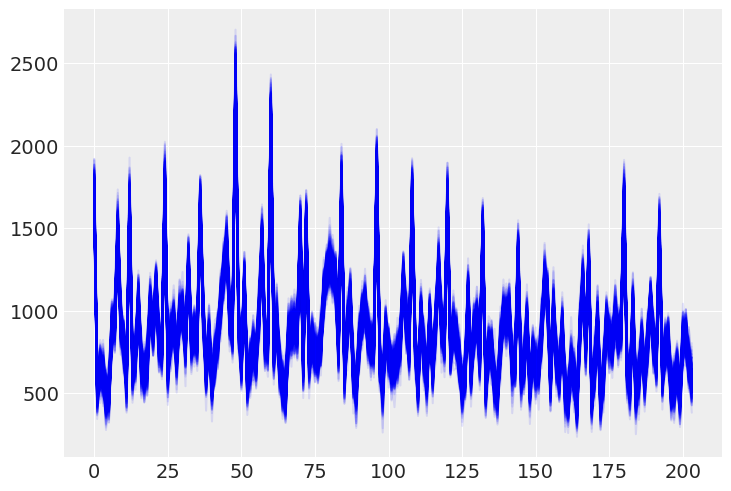

In [54]:
plt.plot(m.pred_samples_fit[:,:,1].T, color='b', alpha=0.1);

In [ ]:
plt.plot(m.pred_samples_predict)

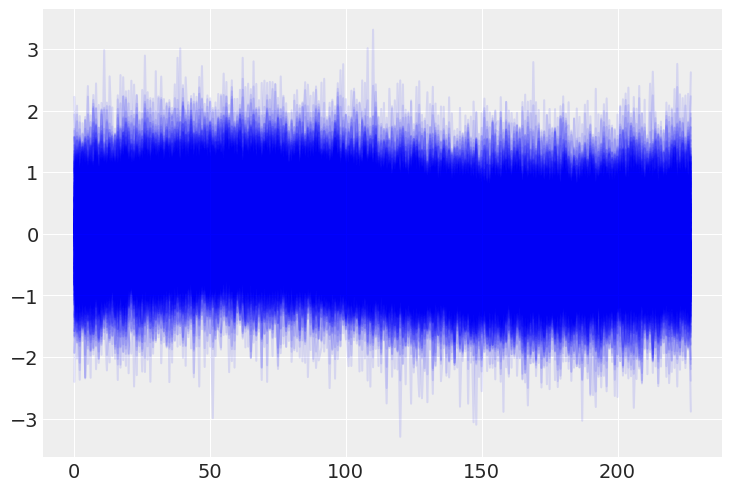

In [36]:
import matplotlib.pyplot as plt

plt.plot(pred_samples_predict['y_pred____new'][:,:,1].T, alpha=0.1, color='b');

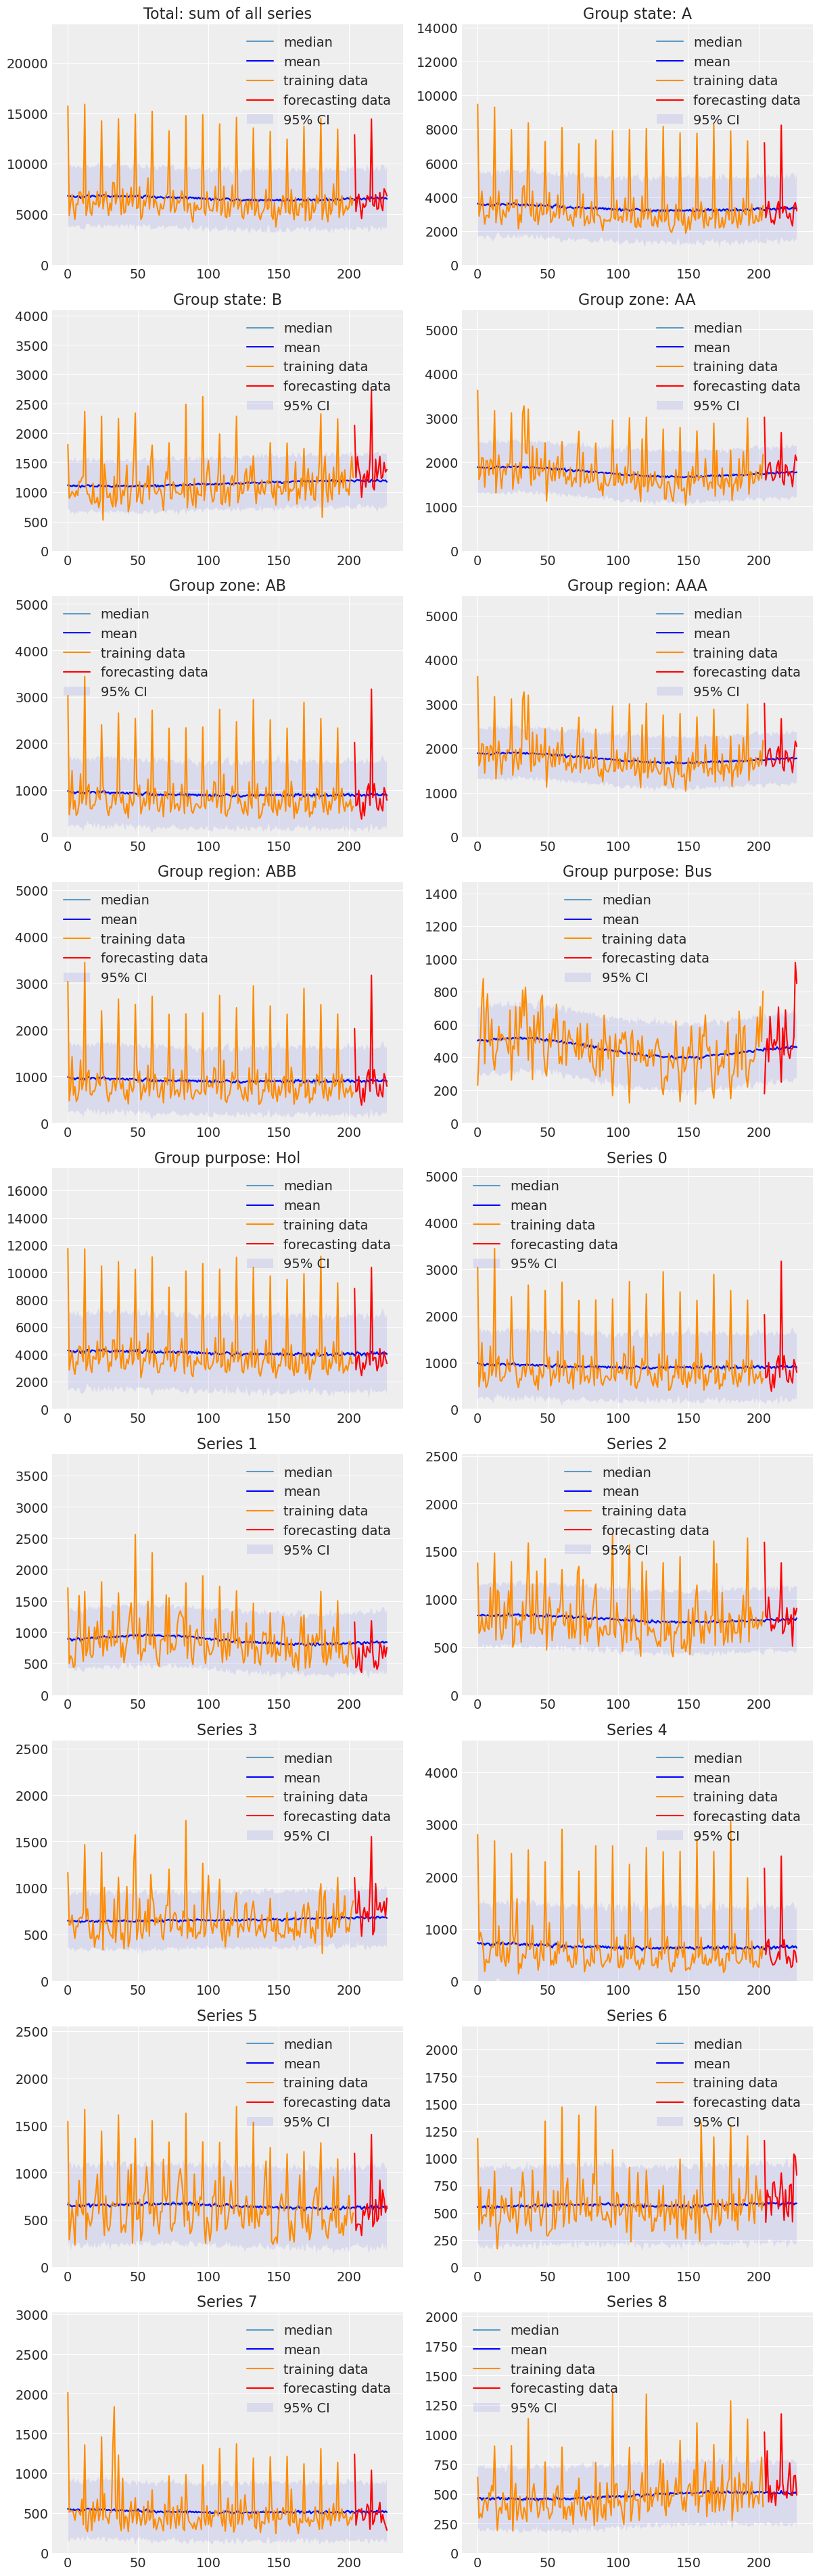

In [11]:
visualize_predict(groups, m.pred_samples_predict, 10)

In [12]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Using one more level of the hierarchy

In [13]:
m = HGPforecaster(groups_data=groups, 
                  levels=['state', 'zone', 'purpose']
                 )
m.fit()

Fitting model...



Sampling...


In [14]:
m.predict()

Sampling...


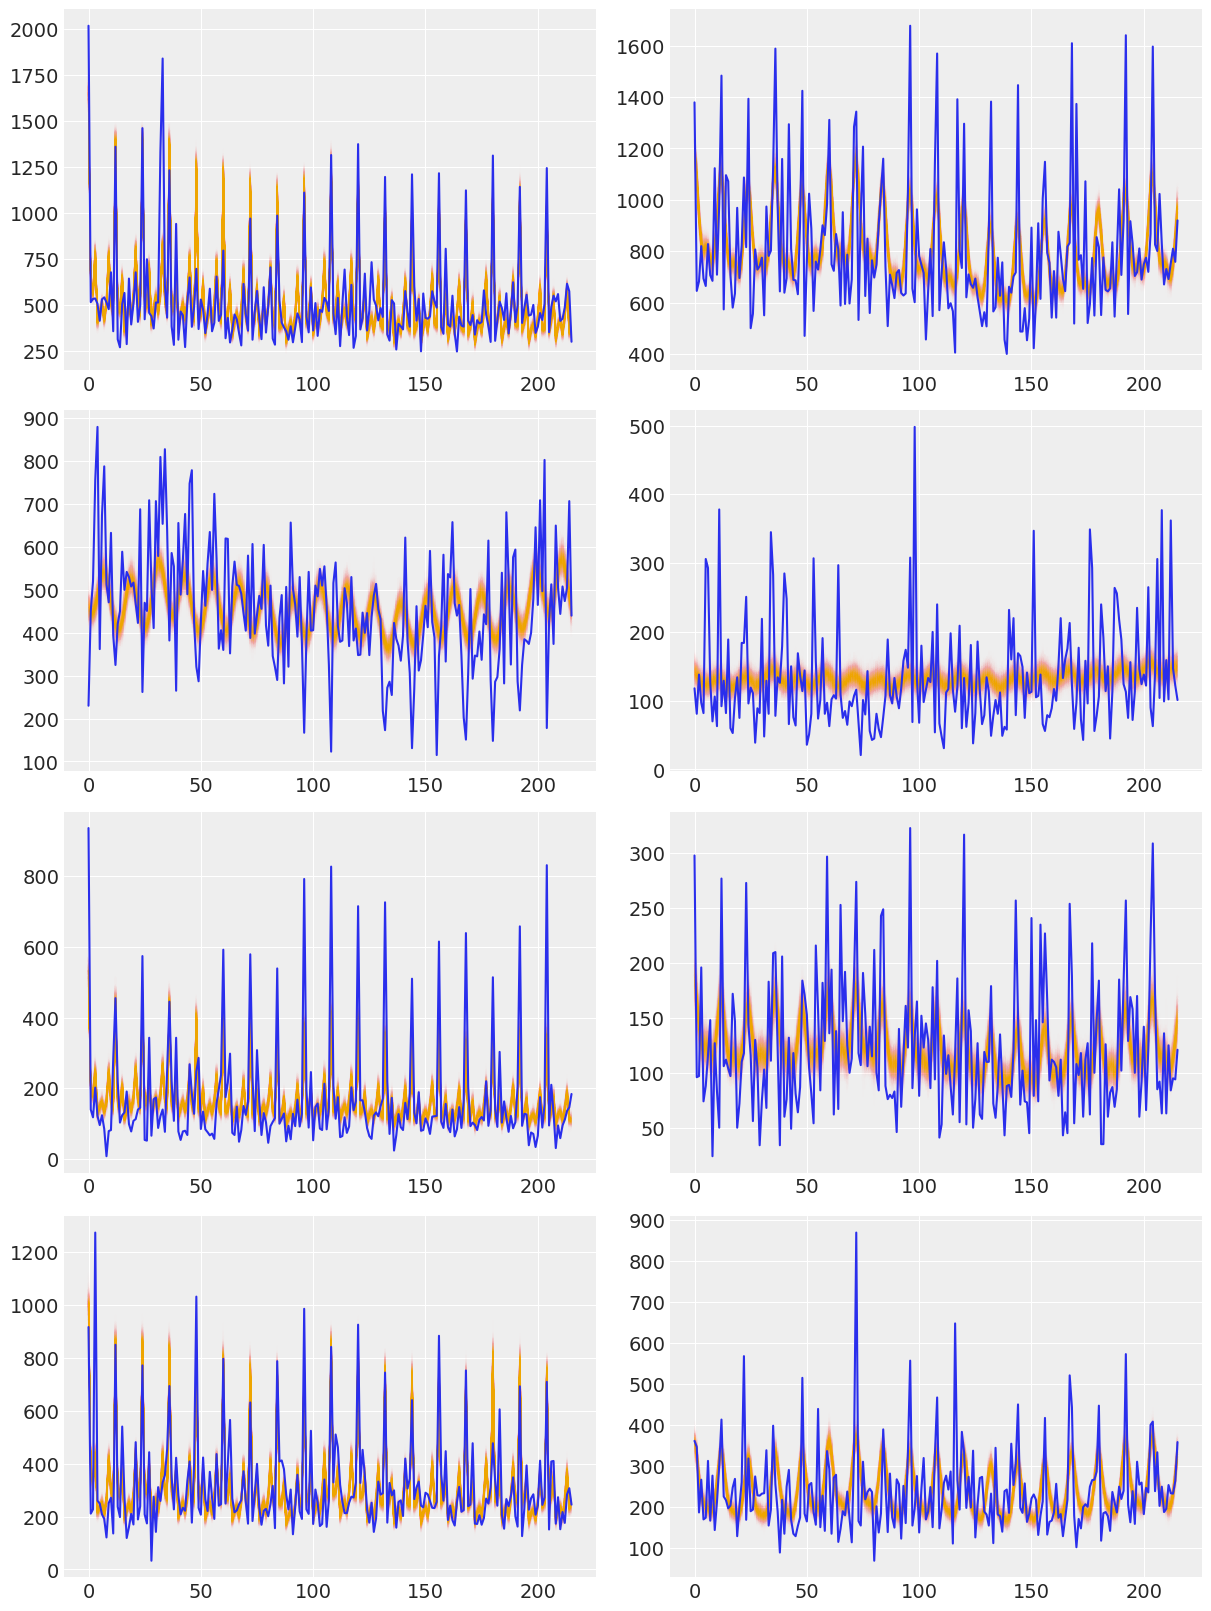

In [15]:
visualize_fit(groups, m.pred_samples_fit, 8)

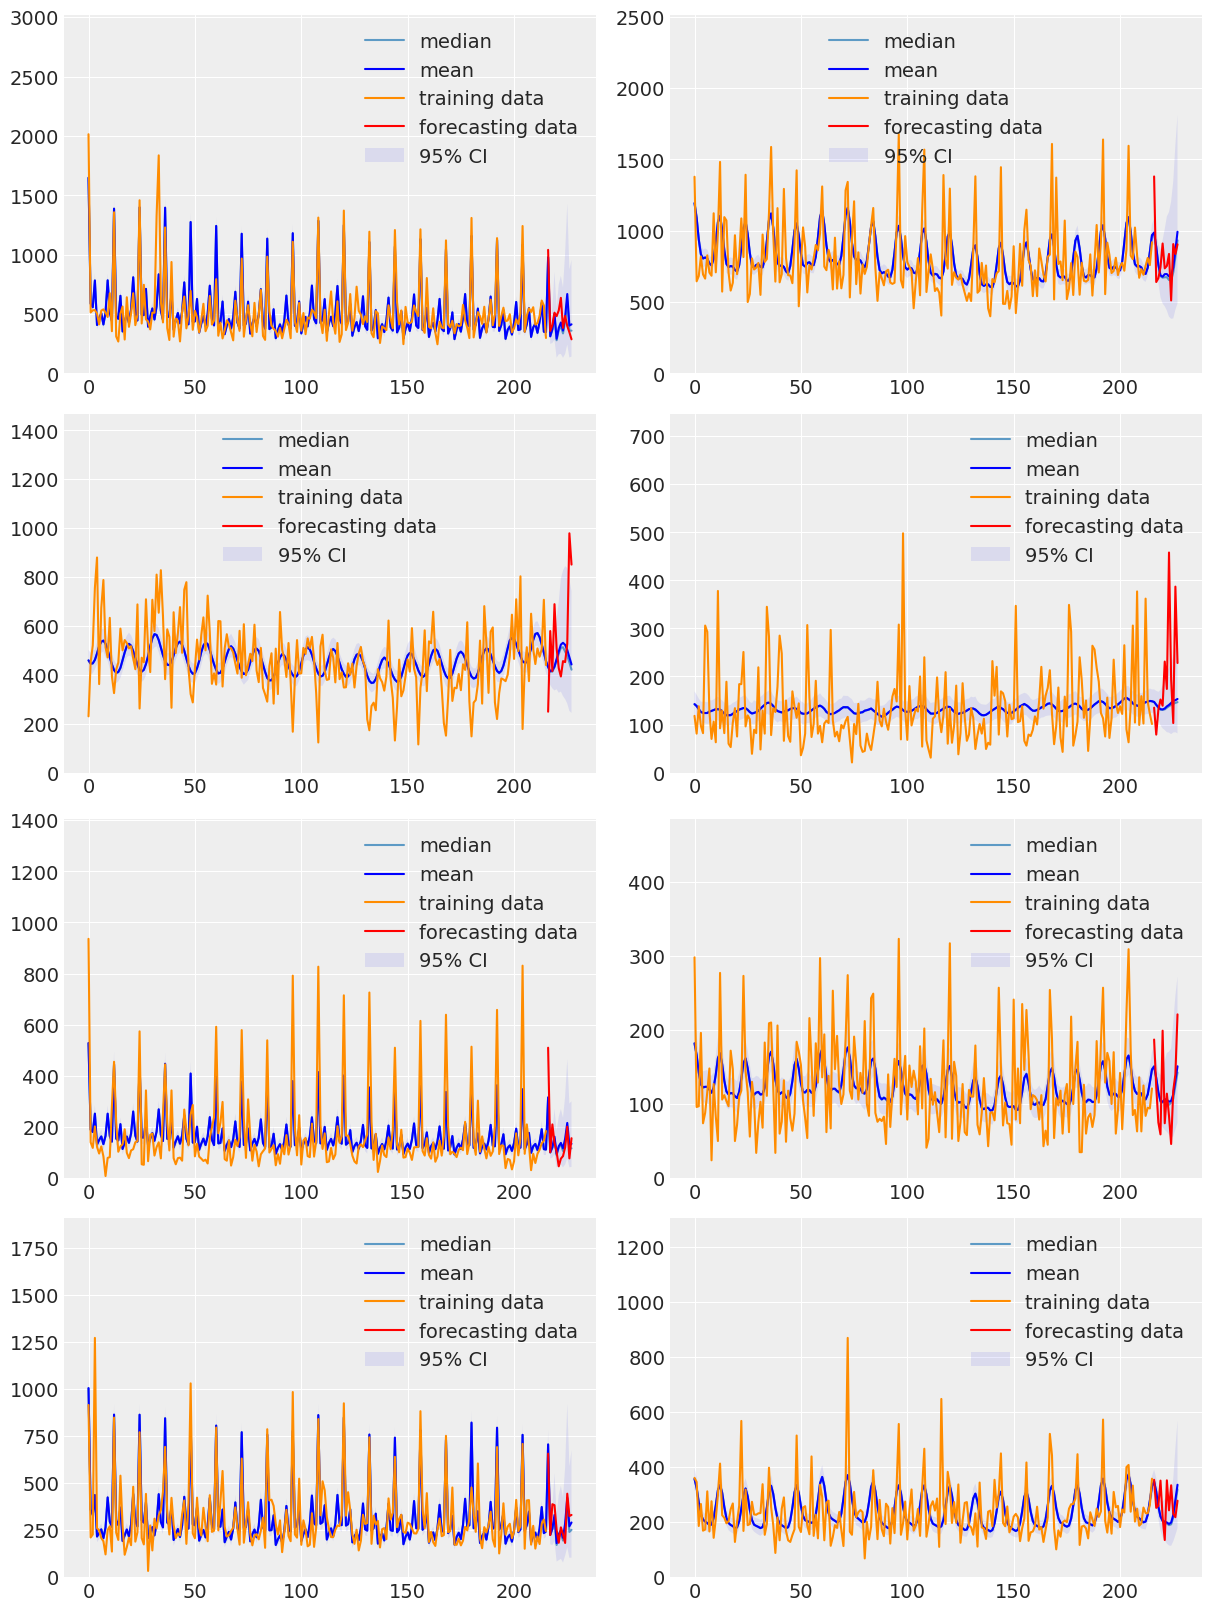

In [16]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [17]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [18]:
metrics_to_table(groups, results)

# Using all levels of the hierarchy

In [19]:
m = HGPforecaster(groups_data=groups
                 )
m.fit()

Fitting model...



Sampling...


In [20]:
m.predict()

Sampling...


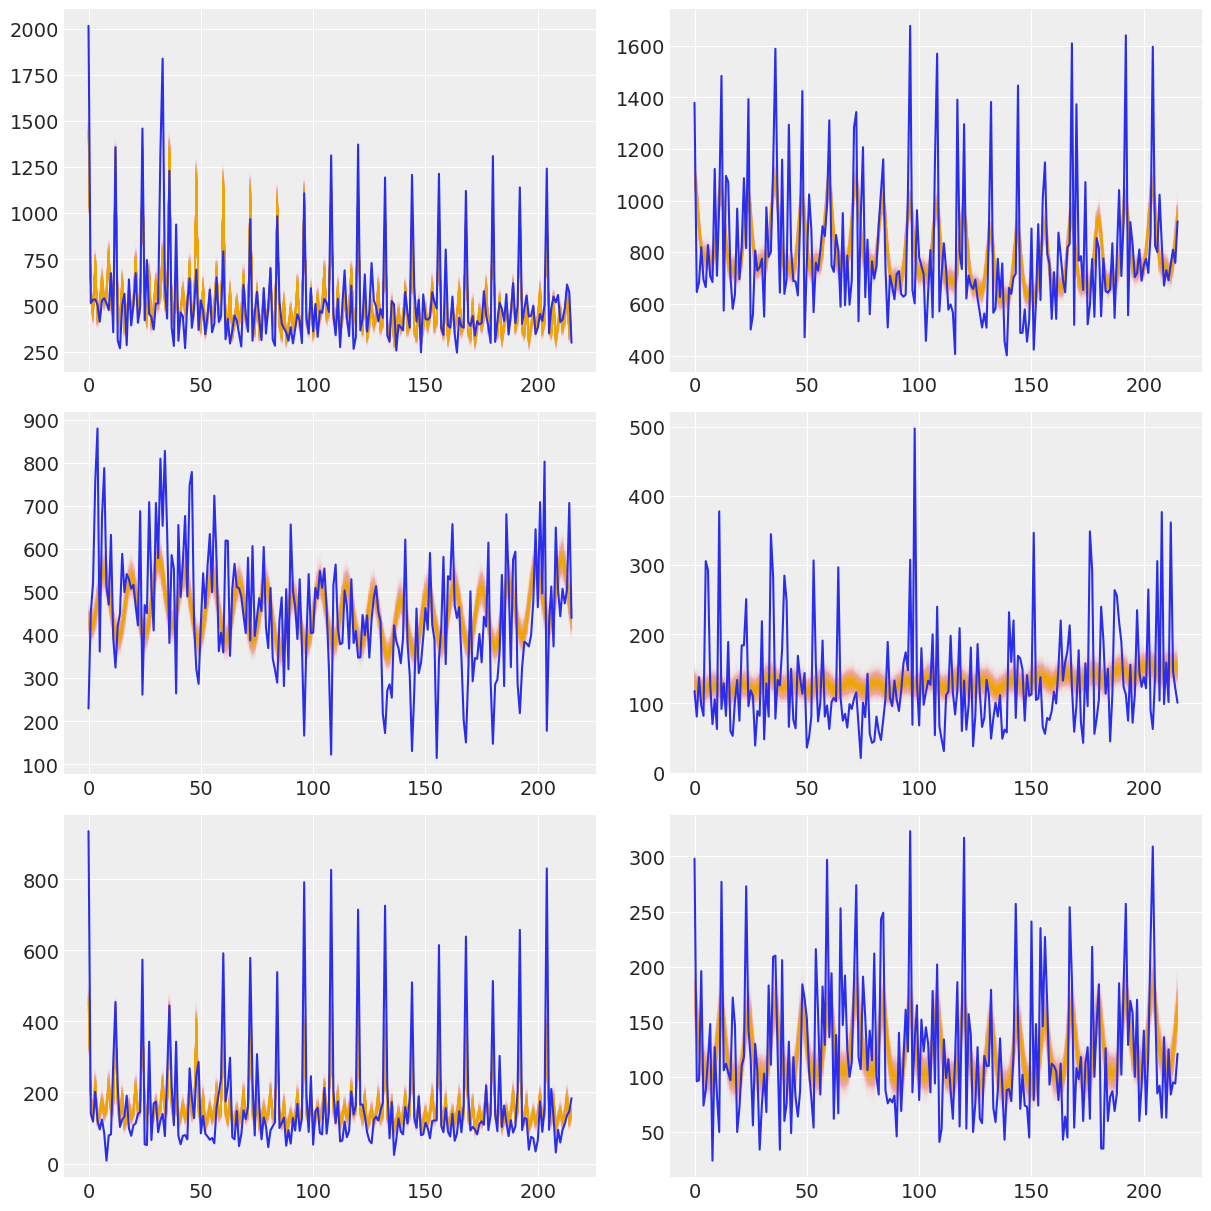

In [39]:
visualize_fit(groups, m.pred_samples_fit, 6)

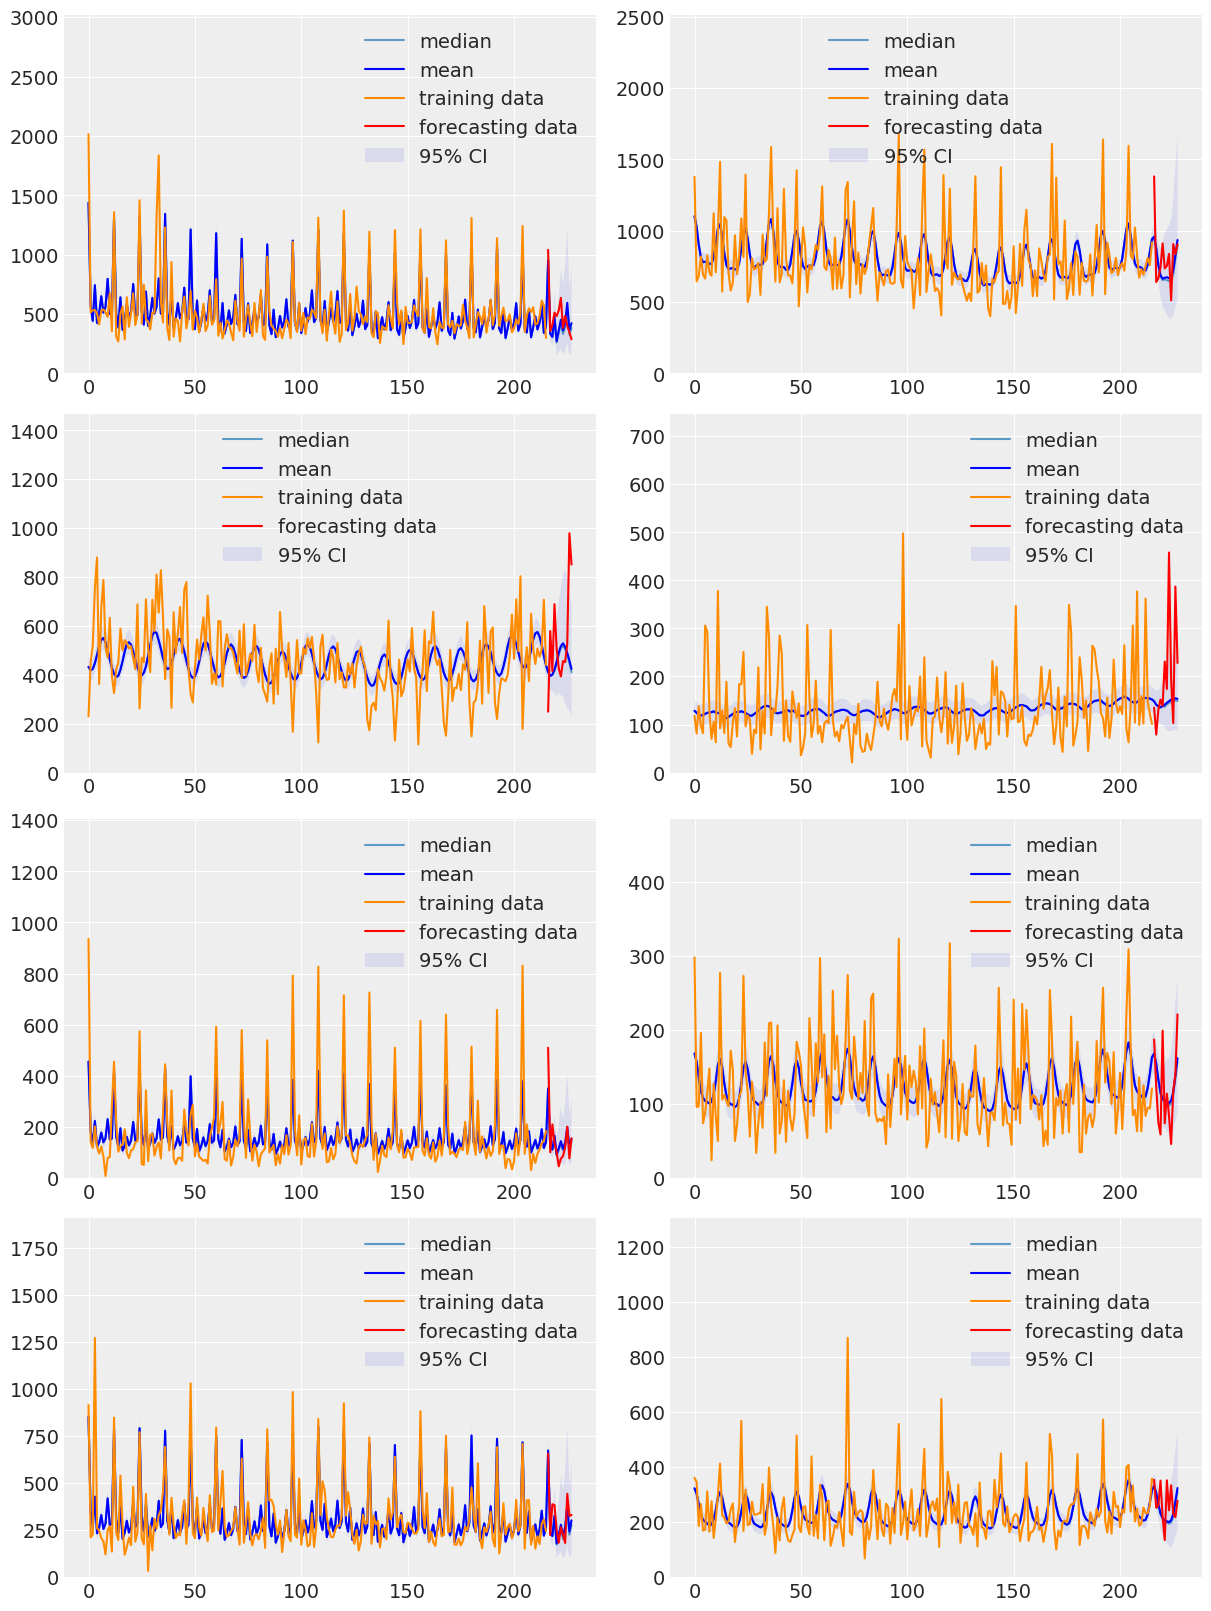

In [22]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [23]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [24]:
metrics_to_table(groups, results)